# Statystyczne metody przetwarzania danych 

## Laboratorium 4 - algorytm normalizacja, selekcja cech.


### Opis
Celem laboratorium jest przeprowadzenie normalizacji i selekcji cech.

### Termin
Zadanie należy wykonać tego samego dnia. 

### System oceniania

| Liczba punktów (procentowo) | Ocena |
| :----                    | ---: |
| [0-50)   | 2   |
| [50-60)  | 3   |
| [60-70)  | 3.5 |
| [70-80)  | 4   |
| [80-90)  | 4.5 |
| [90-100] | 5   |

<u>Punkty ujemne</u>

* `ocena - 0.5` jeżeli zadanie wysłano po laboratorium, ale < 7 dni; 
* `ocena - 1` jeżeli zadanie wysłano w terminie pomiędzy 7 a 14 dni;
* `ocena - 1.5` jeżeli zadanie wysłano po upływie 14 dni, ale przed ostatnim laboratorium;
* `ocena = 2` jeżeli zadanie wysłano po ostatnim laboratorium.

<u>Uwaga:</u>

Niedopuszczalne jest dzielenie się notatnikiem (plik `.ipynb`) z innymi studentami ani udostępnianie go w Internecie. Każdy student powinien pobrać notatnik samodzielnie z platformy WIKAMP.
Wysyłając zadanie potwierdasz, że wykonałeś je samodzielnie i jest to Twoja indywidualna praca a materiał przedstawiony w tej pracy jest dla Ciebie zrozumiały. Prace bardzo podobne albo grupowe będą uznawane za plagiat.


### Zbiór danych

Zbiór danych znajduje się w katalogu `dataset/*`. Jest to zmodyfikowany zbiór danych znajdujący się pod adresem: <https://archive.ics.uci.edu/ml/datasets/leaf>.

### Przesyłanie zadań

Wszystkie pliki należy spakować archiwizatorem **zip** i przesłać za pośrednictwem platformy WIKAMP. Poniżej oczekiwana zawartość archiwum:

```
+-- 📂 [IMIE.NAZWISKO].zip
    +-- 📜 Lab04.ipynb
    +-- 📂 dataset
        +-- 📜 dataset.npz
        +-- 📜 ReadMe.pdf
```

**Pamiętaj, wyniki powinny być czytelnie opisane oraz zaprezentowane graficznie (jeżeli jest taka możliwość). Warstwa prezentacji danych to jeden z głównych elementów wpływających na ocenę.**

Przykład (na podstawie tablicy pomyłek):

**Źle** (nie wiadomo co jest poniżej zaprezentowane, kolumny ani wiersze nie są podpisane, nie wiadomo które z nich prezentują predykcje, a które właściwe etykiety):
```
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
```

### Zadanie

Należy wykonać następujące czynności w celu realizacji niniejszego zadania:

#### Normalizacja
* Wczytaj dane.
* Znormalizuj dane.
* Przeprowadź eksperyment z zastosowaniem algorytmu kNN lub NM dla danych znormalizowanych oraz bez normalizacji.
    * W eksperymencie wybierz minimum 5 klas oraz 10 cech.
* Przedstaw porównanie wyników klasyfikacji na danych znormalizowanych i bez normalizacji.
* Napisz wnioski.


In [22]:
import numpy as np
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score

with open('./dataset/dataset.npz', 'rb') as f:
    data = np.load(f)
    train, test = data['train'], data['test']

test_five_classes = test[((test[:,0] == 3) | (test[:,0] == 5) | (test[:,0] == 6) | (test[:,0] == 7) | (test[:,0] == 8))]
train_five_classes = train[((train[:,0] == 3) | (train[:,0] == 5) | (train[:,0] == 6) | (train[:,0] == 7) | (train[:,0] == 8))]

def normalize_feature(data_set, normalized_set, max_value, min_value, feature):
    for i in range(len(data_set)):
        normalized_set[i, feature] = (data_set[i, feature] - min_value) / (max_value - min_value)

def normalize_data(test_set, train_set, feature_list):
    normalized_test_set = np.copy(test_set)
    normalized_train_set = np.copy(train_set)
    for feature in feature_list:
       max_value = None
       min_value = None
       for sample in test_set:
            if max_value is None or sample[feature] > max_value:
                max_value = sample[feature]
            if min_value is None or sample[feature] < min_value:
                min_value = sample[feature]
       for sample in train_set:
            if max_value is None or sample[feature] > max_value:
                max_value = sample[feature]
            if min_value is None or sample[feature] < min_value:
                min_value = sample[feature]
       normalize_feature(test_set, normalized_test_set, max_value, min_value, feature)
       normalize_feature(train_set, normalized_train_set, max_value, min_value, feature)
    return normalized_test_set, normalized_train_set


class TestSample:
    classified_as = None
    value = None

    def __init__(self, value, classified_as):
        self.value = value
        self.classified_as = classified_as

    def is_properly_classified(self):
        return self.value[0] == self.classified_as

class Neighbour:

    distance = None
    class_value = None

    def __init__(self, class_value, distance):
        self.class_value = class_value
        self.distance = distance

def euclidian_dist(sample1, sample2, features_list):
    value = 0
    for feature in features_list:
        value += (sample1[feature] - sample2[feature]) ** 2
    return math.sqrt(value)

def get_class_from_nearest_neighbours(nearest_neighbours):
    nearest_neighbours_dict = {}
    for nearest_neighbour in nearest_neighbours:
        if nearest_neighbour.class_value in nearest_neighbours_dict:
            nearest_neighbours_dict[nearest_neighbour.class_value].append(nearest_neighbour)
        else:
            nearest_neighbours_dict[nearest_neighbour.class_value] = [nearest_neighbour]
    max_size = 0
    class_value = None
    for k in nearest_neighbours_dict.keys():
        size = len(nearest_neighbours_dict[k])
        if size > max_size:
            max_size = size
            class_value = k
    return class_value

def classify_knn_samples(test_set, train_set, k, features_list):
    classified_samples.clear()
    for test_sample in test_set:
        neighbours = []
        for train_sample in train_set:
            dist = euclidian_dist(test_sample, train_sample, features_list)
            neighbours.append(Neighbour(train_sample[0], dist))
        neighbours.sort(key=lambda x: x.distance, reverse=False)
        nearest_neighbours = neighbours[:k]
        classified_class = get_class_from_nearest_neighbours(nearest_neighbours)
        classified_samples.append(TestSample(test_sample, classified_class))

classified_samples = []
def print_accuracy():
    properly_classified_samples = 0
    for classified_sample in classified_samples:
        if classified_sample.is_properly_classified():
            properly_classified_samples += 1
    print("Accuracy is: " + str(properly_classified_samples / len(classified_samples)))

def fill_classification_data(classified, class_true, class_pred):
    for sample in classified:
        class_true.append(sample.value[0])
        class_pred.append(sample.classified_as)

def print_confusion_matrix(classified):
    class_true = []
    class_pred = []
    fill_classification_data(classified, class_true, class_pred)
    print("Confusion matrix: ")
    print(confusion_matrix(class_true, class_pred))

def print_balanced_accuracy(classified):
    class_true = []
    class_pred = []
    fill_classification_data(classified, class_true, class_pred)
    print("Balanced accuracy is: " + str(balanced_accuracy_score(class_true, class_pred)))

def print_precision_score(classified):
    class_true = []
    class_pred = []
    fill_classification_data(classified, class_true, class_pred)
    print("Precision score (avg='weighted') is: " + str(precision_score(class_true, class_pred, average='weighted')))

def print_classification_parameters(classified):
    print_accuracy()
    print_balanced_accuracy(classified)
    print_precision_score(classified)
    print_confusion_matrix(classified)

features = [2, 3, 4, 5, 6, 7, 8, 9, 12, 15]
test_normalized_five_classes, train_normalized_five_classes = normalize_data(test_five_classes, train_five_classes, features)

print("Not normalized - 5 classes {3, 5, 6, 7, 8}, 10 features {2, 3, 4, 5, 6, 7, 8, 9, 12, 15}, k 21")
classify_knn_samples(test_five_classes, train_five_classes, 21, features)
print("kNN:")
print_classification_parameters(classified_samples)

print("Normalized - 5 classes {3, 5, 6, 7, 8}, 10 features {2, 3, 4, 5, 6, 7, 8, 9, 12, 15}, k 21")
classify_knn_samples(test_normalized_five_classes, train_normalized_five_classes, 21, features)
print("kNN:")
print_classification_parameters(classified_samples)


Not normalized - 5 classes {3, 5, 6, 7, 8}, 10 features {2, 3, 4, 5, 6, 7, 8, 9, 12, 15}, k 21
kNN:
Accuracy is: 0.974025974025974
Balanced accuracy is: 0.9751515151515152
Precision score (avg='weighted') is: 0.9748768472906404
Confusion matrix: 
[[54  0  0  1  0]
 [ 0 55  0  0  0]
 [ 0  0 44  0  0]
 [ 4  3  0 59  0]
 [ 0  0  0  0 88]]
Normalized - 5 classes {3, 5, 6, 7, 8}, 10 features {2, 3, 4, 5, 6, 7, 8, 9, 12, 15}, k 21
kNN:
Accuracy is: 0.9772727272727273
Balanced accuracy is: 0.9769696969696969
Precision score (avg='weighted') is: 0.9780033525796238
Confusion matrix: 
[[52  0  0  3  0]
 [ 0 55  0  0  0]
 [ 0  0 44  0  0]
 [ 0  4  0 62  0]
 [ 0  0  0  0 88]]


#### Selekcja cech
* Przeprowadź selekcję cech za pomocą metod poznanych na wykładzie (np. z zastosowaniem współczynnika Fishera)
    * Wybierz 2-5 cech (ze zbioru 10 cech wybranych w poprzednim eksperymencie) i opisz dlaczego je wybrałeś.
* Przeprowadź klasyfikację na wybranych cechach.
* Porównaj wyniki klasyfikacji:
    * dla 10 cech bez normalizacji,
    * dla 10 cech z normalizacją,
    * dla 2-5 cech bez normalizacji,
    * dla 2-5 cech z normalizacją.
* Opisz wyniki i napisz wnioski.


Not normalized - 5 classes {3, 5, 6, 7, 8}, 10 features {2, 3, 4, 5, 6, 7, 8, 9, 12, 15}, k 21
kNN:
Accuracy is: 0.974025974025974
Balanced accuracy is: 0.9751515151515152
Precision score (avg='weighted') is: 0.9748768472906404
Confusion matrix: 
[[54  0  0  1  0]
 [ 0 55  0  0  0]
 [ 0  0 44  0  0]
 [ 4  3  0 59  0]
 [ 0  0  0  0 88]]
Normalized - 5 classes {3, 5, 6, 7, 8}, 10 features {2, 3, 4, 5, 6, 7, 8, 9, 12, 15}, k 21
kNN:
Accuracy is: 0.9772727272727273
Balanced accuracy is: 0.9769696969696969
Precision score (avg='weighted') is: 0.9780033525796238
Confusion matrix: 
[[52  0  0  3  0]
 [ 0 55  0  0  0]
 [ 0  0 44  0  0]
 [ 0  4  0 62  0]
 [ 0  0  0  0 88]]
Not normalized - 5 classes {3, 5, 6, 7, 8}, 2 features {5, 15}, k 21
kNN:
Accuracy is: 0.4512987012987013
Balanced accuracy is: 0.46818181818181814
Precision score (avg='weighted') is: 0.41161341117782857
Confusion matrix: 
[[10  6 12  6 21]
 [ 1 35  3 13  3]
 [ 0  1 38  2  3]
 [ 8 19 21  6 12]
 [12  6 13  7 50]]
Normalized -

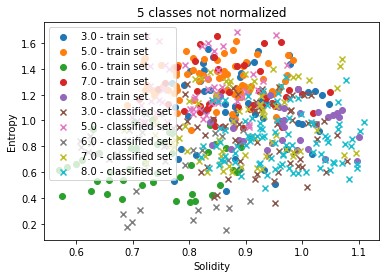

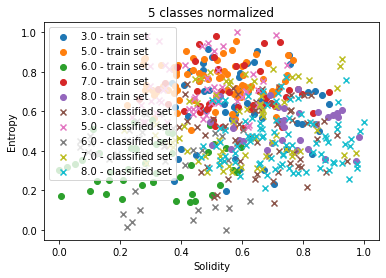

In [28]:
import matplotlib.pyplot as plt

def get_grouped_set_dict(dataset):
    grouped_dict = {}
    for element in dataset:
        if element[0] in grouped_dict:
            grouped_dict[element[0]].append(element)
        else:
            grouped_dict[element[0]] = [element]
    for key in grouped_dict.keys():
        grouped_dict[key] = np.asarray(grouped_dict[key])
    return grouped_dict

def get_grouped_classified_set_dict(classified):
    grouped_dict = {}
    for element in classified:
        if element.value[0] in grouped_dict:
            grouped_dict[element.value[0]].append(element.value)
        else:
            grouped_dict[element.value[0]] = [element.value]
    for key in grouped_dict.keys():
        grouped_dict[key] = np.asarray(grouped_dict[key])
    return grouped_dict

def draw_visualization_2d(title, train_set, feature1, feature2, feature1_name, feature2_name):
    grouped_five_classes_train_dict = get_grouped_set_dict(train_set)
    classified_samples_dict = get_grouped_classified_set_dict(classified_samples)
    plt.figure()
    plt.title(title)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    for k in sorted(grouped_five_classes_train_dict.keys()):
        plt.scatter(x=grouped_five_classes_train_dict[k][:, feature1], y=grouped_five_classes_train_dict[k][:, feature2], label=str(k) + ' - train set', marker='o')
    for k in sorted(classified_samples_dict.keys()):
        plt.scatter(x=classified_samples_dict[k][:, feature1], y=classified_samples_dict[k][:, feature2], label=str(k) + ' - classified set', marker='x')
    plt.legend()

features = [2, 3, 4, 5, 6, 7, 8, 9, 12, 15]
test_normalized_five_classes, train_normalized_five_classes = normalize_data(test_five_classes, train_five_classes, features)

print("Not normalized - 5 classes {3, 5, 6, 7, 8}, 10 features {2, 3, 4, 5, 6, 7, 8, 9, 12, 15}, k 21")
classify_knn_samples(test_five_classes, train_five_classes, 21, features)
print("kNN:")
print_classification_parameters(classified_samples)

print("Normalized - 5 classes {3, 5, 6, 7, 8}, 10 features {2, 3, 4, 5, 6, 7, 8, 9, 12, 15}, k 21")
classify_knn_samples(test_normalized_five_classes, train_normalized_five_classes, 21, features)
print("kNN:")
print_classification_parameters(classified_samples)

features = [5, 15]
test_normalized_five_classes, train_normalized_five_classes = normalize_data(test_five_classes, train_five_classes, features)

print("Not normalized - 5 classes {3, 5, 6, 7, 8}, 2 features {5, 15}, k 21")
classify_knn_samples(test_five_classes, train_five_classes, 21, features)
print("kNN:")
print_classification_parameters(classified_samples)
# VISUAL REPRESENTATION FOR 2-FEATURES CASE
draw_visualization_2d("5 classes not normalized", train_five_classes, 5, 15, "Solidity", "Entropy")

print("Normalized - 5 classes {3, 5, 6, 7, 8}, 10 features {5, 15}, k 21")
classify_knn_samples(test_normalized_five_classes, train_normalized_five_classes, 21, features)
print("kNN:")
print_classification_parameters(classified_samples)
# VISUAL REPRESENTATION FOR 2-FEATURES CASE
draw_visualization_2d("5 classes normalized", train_normalized_five_classes, 5, 15, "Solidity", "Entropy")
